In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai.basics as fai
import fastai.vision as fv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import numpy as np
from pathlib import Path
import random
import gc

from torch.utils.data import Dataset
from torchvision import transforms, utils

import PIL

In [3]:
#!mkdir /home/jupyter/redes-2/FaceAging/Data

In [4]:
#!gsutil -m cp -r gs://fastai_bucket/crop_part1 /home/jupyter/redes-2/FaceAging/Data

In [5]:
path = Path('Data/UTKFace/')

In [6]:
def is_listy(x):
    return isinstance(x, (list,tuple))

class AgeSexItem(fv.ItemBase):
    def __init__(self,array):
        self.data = np.array(array).astype(np.float32)
    
    def __str__(self):
        L = ["Male","Female"]
        return str(self.data[0]) + " / " + L[int(self.data[1] > 0.5)]

class AgeSexList(fv.ItemList):
    def __init__(self, items:fv.Iterator, **kwargs):
        super().__init__(np.array(items, dtype=np.float32), **kwargs)
        
        
        self.c = items.shape[1]
    
    def get(self,i):
        o = super().get(i)
        return AgeSexItem(o)
    
    def reconstruct(self,t):
        if is_listy(t):
            return AgeSexItem(np.array(t))
        return AgeSexItem(t.numpy())

In [7]:
def extract_age_sex(filename):
    f=filename.stem.split("_")
    return float(f[0]), float(f[1])

In [8]:
def load_face_data(img_size, batch_size, amount=1.):
    tfms = fv.get_transforms(max_warp=0.)
    return (fv.ImageItemList.from_folder(path)
           .filter_by_rand(amount,seed=13)
           .random_split_by_pct(0.1,seed=13)
           .label_from_func(extract_age_sex,label_cls=AgeSexList)
           .transform(tfms, size=img_size)
           .databunch(bs=batch_size))

In [9]:
data = load_face_data(256,64)

In [10]:
#data.show_batch(rows=3,seed=13)

In [11]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.squeeze()

def num_params(model):
    total=0
    for p in list(model.parameters()):
        num=1
        for s in list(p.size()):
            num *= s
        total += num
    return total

In [12]:
class Net(nn.Module):
    def __init__(self, filters, p = 0.33):
        super().__init__()
        ni = filters[0]
        layers = list(fv.models.resnet34(pretrained=True).children())[:-2]
        layers += [fai.AdaptiveConcatPool2d(), fai.Flatten()]
        
        for ni,no in zip(filters[:-1], filters[1:]):
            layers += [nn.LeakyReLU(),
                       nn.BatchNorm1d(ni),
                       nn.Dropout(p),
                       nn.Linear(ni,no)]
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        scale = torch.tensor([117.,1.]).cuda()
        out = self.net(x)
        out = out.sigmoid()
        out = out.mul(scale)
        return out
filters = [1024,512,128,64,2]
model = Net(filters)
#model
num_params(model)

21886978

In [13]:
def age_sex_loss(pred,targ):
    age_p = pred.select(1,0).cuda()
    age_t = targ.select(1,0).cuda()
    sex_p = pred.select(1,1).cuda()
    sex_t = targ.select(1,1).cuda()
    p = (1+age_p)**0.3
    t = (1+age_t)**0.3
    age_loss = F.l1_loss(p,t)
    sex_loss = F.binary_cross_entropy(sex_p,sex_t)
    return age_loss*0.85+sex_loss*0.15

In [14]:
gc.collect()

231

In [15]:
learner = fai.Learner(data, model, loss_func=age_sex_loss, wd=0.1)

In [16]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss
1,0.377499,0.301059
2,0.278126,0.250570
3,0.237659,0.212870
4,0.204934,0.173890
5,0.185358,0.161659


In [ ]:
fdaf

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


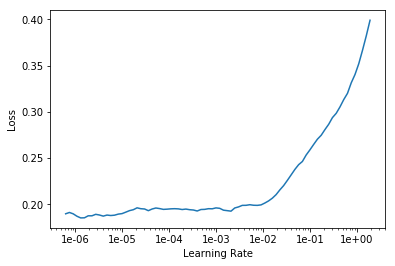

In [19]:
learner.lr_find(); learner.recorder.plot()

In [20]:
learner.fit_one_cycle(5,max_lr=2e-3)

epoch,train_loss,valid_loss
1,0.200471,0.196426
2,0.207839,0.177701
3,0.192079,0.193341
4,0.177089,0.154239
5,0.170023,0.142150


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


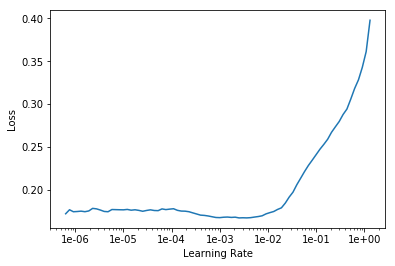

In [26]:
learner.lr_find(); learner.recorder.plot()

In [25]:
learner.unfreeze()

In [27]:
learner.fit_one_cycle(4,max_lr=2e-3)

epoch,train_loss,valid_loss
1,0.186824,0.194179
2,0.187261,0.176037
3,0.180841,0.145620
4,0.163400,0.140210


In [ ]:
learner.lr_find(); learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(5,max_lr=1e-2)

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find();learner.recorder.plot()

In [21]:
learner.save("face_resnet34")

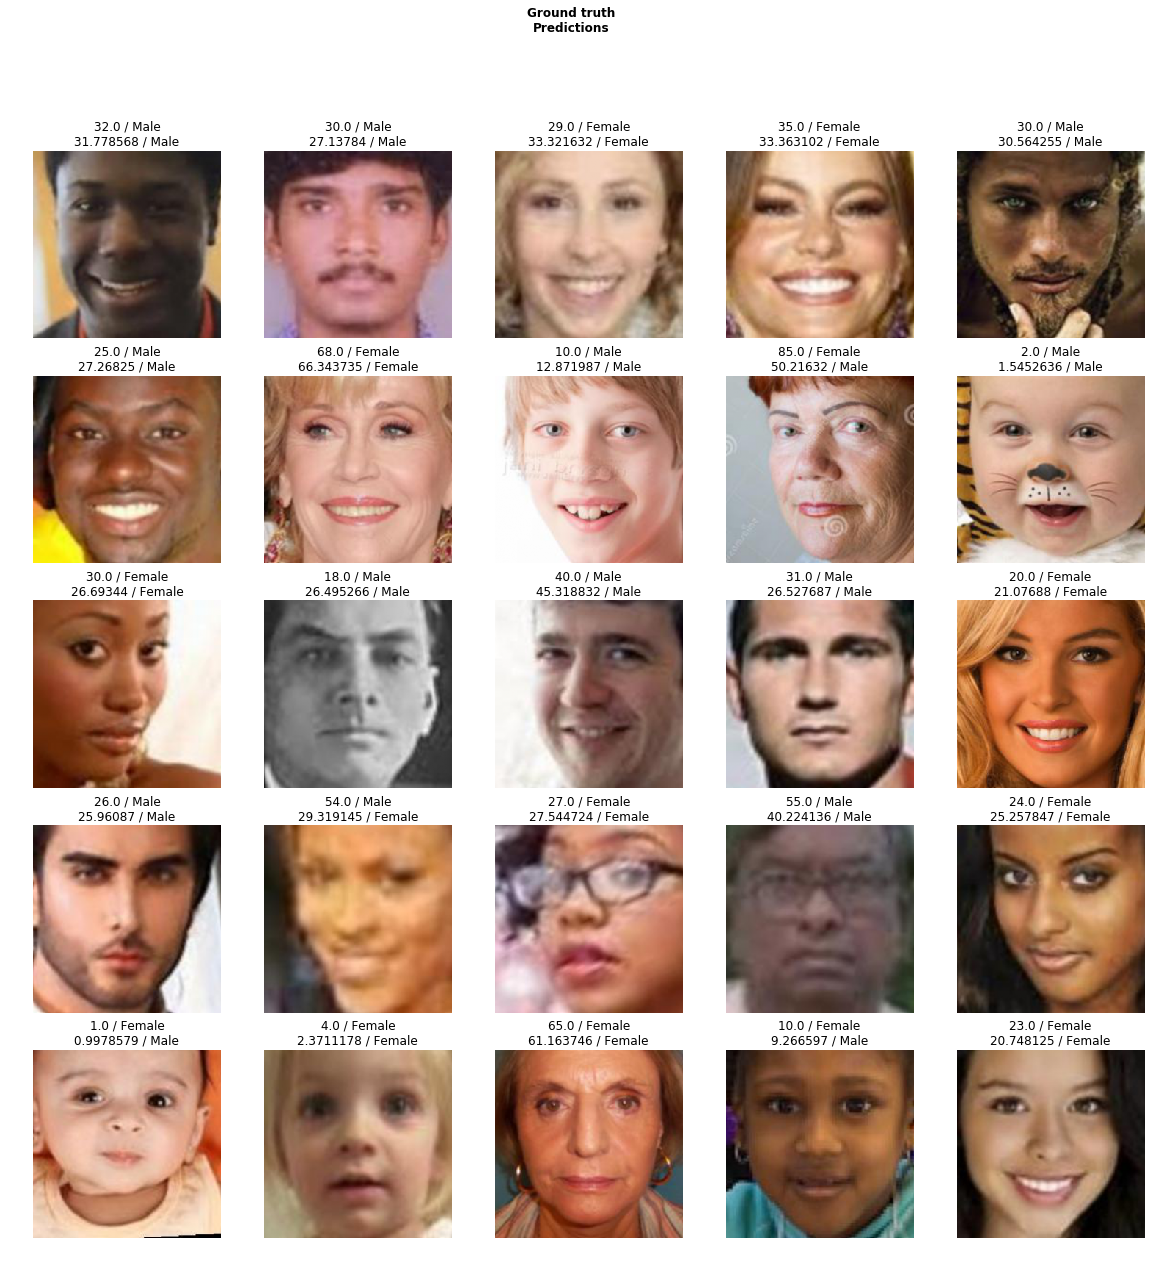

In [28]:
learner.show_results(rows=5)

In [ ]:
learner.loss_func=age_sex_loss

In [ ]:
learner.lr_find();learner.recorder.plot()